# Gradient Boosting Significant Others - with XGBoost

Using European survey data to predict whether participants have a significant other or not.

## Imports

In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import timeit
from datetime import datetime

from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn import metrics
from sklearn import ensemble

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
Y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'], drop_first=True)], axis=1)

## Understanding the Data

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8147 entries, 0 to 8593
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     8147 non-null   int64  
 1   tvtot    8147 non-null   float64
 2   ppltrst  8147 non-null   float64
 3   pplfair  8147 non-null   float64
 4   pplhlp   8147 non-null   float64
 5   happy    8147 non-null   float64
 6   sclmeet  8147 non-null   float64
 7   sclact   8147 non-null   float64
 8   gndr     8147 non-null   float64
 9   agea     8147 non-null   float64
 10  CZ       8147 non-null   uint8  
 11  DE       8147 non-null   uint8  
 12  ES       8147 non-null   uint8  
 13  NO       8147 non-null   uint8  
 14  SE       8147 non-null   uint8  
dtypes: float64(9), int64(1), uint8(5)
memory usage: 739.9 KB


In [4]:
X.describe()

,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,CZ,DE,ES,NO,SE
count,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000
mean,6.500307,3.818584,5.574936,6.005155,5.321468,7.708482,5.215908,2.755984,1.496379,47.262182,0.148153,0.003314,0.281331,0.174297,0.211857
std,0.500031,2.008937,2.215745,2.120127,2.166217,1.720839,1.438792,0.901406,0.500018,18.316890,0.355273,0.057476,0.449676,0.379388,0.408649
min,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,2.000000,4.000000,5.000000,4.000000,7.000000,4.000000,2.000000,1.000000,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,4.000000,6.000000,6.000000,5.000000,8.000000,6.000000,3.000000,1.000000,47.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,5.000000,7.000000,8.000000,7.000000,9.000000,6.000000,3.000000,2.000000,61.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,7.000000,7.000000,10.000000,10.000000,10.000000,10.000000,7.000000,5.000000,2.000000,114.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
X.head()

,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,CZ,DE,ES,NO,SE
0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,0,0,0,0,0
1,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,0,0,0,0,0
2,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,0,0,0,0,0
3,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,0,0,0,0,0
4,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,0,0,0,0,0


In [6]:
df['cntry'].value_counts()

ES    2292
SE    1726
CH    1475
NO    1420
CZ    1207
DE      27
Name: cntry, dtype: int64

In [7]:
# Turning gender variable into binary
X['gndr'] = X['gndr'] -1

In [8]:
# Dropping year because it makes little intuitive impact on our outcome

X = X.drop('year', axis=1)

In [9]:
X.shape

(8147, 14)

In [10]:
X.isnull().sum()

tvtot      0
ppltrst    0
pplfair    0
pplhlp     0
happy      0
sclmeet    0
sclact     0
gndr       0
agea       0
CZ         0
DE         0
ES         0
NO         0
SE         0
dtype: int64

### DRILL: Tune a gradient boosting model

How low can I get the error rates to go in the test set, based on my model in the training set? I can try:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

A few parameters to tune could be:
 - learning_rate
 - max_depth
 - n_estimators
 - loss
 - subsample
 - min_samples_split


## Modeling Phase

In [11]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score

xgb.XGBClassifier()

C:\Users\sebar\Anaconda3\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=False, verbosity=None)

## 1. Tuning Estimators

In [12]:
# Timer Function

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [13]:
param_test1 = {'n_estimators': range(20, 201, 10)}

clf = xgb.XGBClassifier(learning_rate= 0.05, subsample= 0.8, max_depth=5, min_child_weight=1, gamma=0, colsample_bytree=0.8, random_state= 42)

grid_search= GridSearchCV(clf, param_grid=param_test1, scoring='accuracy', n_jobs=-1, iid=False, cv=5, verbose=3)

start_time = timer(None)

grid_search.fit(X, Y);

timer(start_time)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   49.3s finished
C:\Users\sebar\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning



 Time taken: 0 hours 0 minutes and 50.13 seconds.


In [14]:
grid_search.best_params_, grid_search.best_score_

({'n_estimators': 110}, 0.7516890561035224)

50 trees seems to be the ideal number of estimators for this set of parameters. Let's fix that value and tune max_depth and min_child_weight.

In [15]:
pd.options.display.max_columns = 100
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.265289,0.004370,0.004787,0.000399,20,{'n_estimators': 20},0.764417,0.732515,0.763045,0.732351,0.748312,0.748128,0.014004,17
1,0.375993,0.003989,0.005785,0.000399,30,{'n_estimators': 30},0.766258,0.728834,0.761203,0.732965,0.753223,0.748497,0.015014,14
2,0.510034,0.029380,0.006782,0.000399,40,{'n_estimators': 40},0.766871,0.732515,0.763659,0.731123,0.753223,0.749478,0.015115,13
3,0.834566,0.145142,0.008578,0.000799,50,{'n_estimators': 50},0.769939,0.729448,0.766114,0.732965,0.753837,0.750460,0.016634,5
4,1.008302,0.101295,0.009973,0.001261,60,{'n_estimators': 60},0.768098,0.725767,0.766114,0.736034,0.755678,0.750338,0.016740,6
5,1.357767,0.212909,0.024534,0.024337,70,{'n_estimators': 70},0.768712,0.727607,0.767956,0.737262,0.754451,0.751198,0.016425,2
6,2.398581,0.121073,0.013962,0.003624,80,{'n_estimators': 80},0.766871,0.720245,0.767342,0.738490,0.757520,0.750094,0.018219,8
7,1.797390,0.442989,0.011170,0.000399,90,{'n_estimators': 90},0.770552,0.719018,0.765500,0.739104,0.754451,0.749725,0.018765,11
8,1.615887,0.165016,0.015559,0.006451,100,{'n_estimators': 100},0.768098,0.719632,0.773481,0.740945,0.753223,0.751076,0.019430,3
9,2.152251,0.212466,0.022146,0.008260,110,{'n_estimators': 110},0.769325,0.723313,0.771639,0.740331,0.753837,0.751689,0.018154,1


## 2. Tuning max_depth and min_child_weight.

We tune these first as they will have the highest impact on model outcome. To start with, let’s set wider ranges and then we will perform another iteration for smaller ranges.

In [16]:
param_test2 = {'max_depth': range(3, 10, 2), 'min_child_weight':range(1, 6, 2)}

clf = xgb.XGBClassifier(n_estimators= 50, learning_rate= 0.05, subsample= 0.8, max_depth=5, min_child_weight=1, gamma=0, colsample_bytree=0.8, random_state= 42)

grid_search= GridSearchCV(clf, param_grid=param_test2, scoring='accuracy', n_jobs=-1, iid=False, cv=5, verbose=3)

start_time = timer(None)

grid_search.fit(X, Y)

timer(start_time)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   12.7s finished
C:\Users\sebar\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning



 Time taken: 0 hours 0 minutes and 13.1 seconds.


In [17]:
grid_search.best_params_, grid_search.best_score_

({'max_depth': 5, 'min_child_weight': 3}, 0.7513199787592223)

Here, we have run 12 combinations with wider intervals between values. The ideal values are 5 for max_depth and 1 for min_child_weight. Lets go one step deeper and look for optimum values. We’ll search for values 1 above and below the optimum values because we took an interval of two.

In [18]:
# 50 trees seems to be the ideal number of estimators for this set of parameters. Let's fix that value and tune max_depth and min_child_weight.

param_test3 = {'max_depth': [4, 5, 6], 'min_child_weight': [1, 2]}

clf = xgb.XGBClassifier(n_estimators= 50, learning_rate= 0.05, subsample= 0.8, max_depth=5, min_child_weight=1, gamma=0, colsample_bytree=0.8, random_state= 42)

grid_search= GridSearchCV(clf, param_grid=param_test3, scoring='accuracy', n_jobs=-1, iid=False, cv=5, verbose=3)

start_time = timer(None)

grid_search.fit(X, Y)

timer(start_time)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.2s finished
C:\Users\sebar\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning



 Time taken: 0 hours 0 minutes and 7.95 seconds.


In [19]:
grid_search.best_params_, grid_search.best_score_

({'max_depth': 5, 'min_child_weight': 1}, 0.7504604804784447)

It looks like the ideal max_depth value is 6. We'll stick to that. Also we can notice a slight increase in our cv score.

## 3. Tuning Gamma

In [20]:
param_test4 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

clf = xgb.XGBClassifier(n_estimators= 50, learning_rate= 0.05, subsample= 0.8, max_depth=6, min_child_weight=1, gamma=0, colsample_bytree=0.8, random_state= 42)

grid_search= GridSearchCV(clf, param_grid=param_test4, scoring='accuracy', n_jobs=-1, iid=False, cv=5, verbose=3)

start_time = timer(None)

grid_search.fit(X, Y)

timer(start_time)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    9.1s finished
C:\Users\sebar\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning



 Time taken: 0 hours 0 minutes and 9.69 seconds.


In [21]:
grid_search.best_params_, grid_search.best_score_

({'gamma': 0.4}, 0.7523026283579448)

In [22]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.332245,0.142733,0.012368,0.002570,0,{'gamma': 0.0},0.769939,0.726994,0.765500,0.740331,0.748312,0.750215,0.015895,5
1,1.583412,0.094059,0.015957,0.005390,0.1,{'gamma': 0.1},0.765644,0.727607,0.764886,0.742173,0.751381,0.750338,0.014355,3
2,1.575905,0.041388,0.026927,0.009033,0.2,{'gamma': 0.2},0.765644,0.726994,0.767342,0.742173,0.748926,0.750216,0.015079,4
3,1.255643,0.148962,0.012070,0.002450,0.3,{'gamma': 0.3},0.766871,0.725767,0.769184,0.742787,0.754451,0.751812,0.016095,2
4,0.882975,0.082054,0.010765,0.002567,0.4,{'gamma': 0.4},0.766871,0.728221,0.769797,0.740331,0.756292,0.752303,0.015859,1


This shows that our original value of gamma, i.e. 0 is the optimum one. Before proceeding, a good idea would be to re-calibrate the number of boosting rounds for the updated parameters.

## 4. Updating optimal number of estimators

In [23]:
param_test1 = {'n_estimators': range(20, 201, 10)}

clf = xgb.XGBClassifier(learning_rate= 0.05, subsample= 0.8, max_depth=6, min_child_weight=1, gamma=0, colsample_bytree=0.8, random_state= 42)

grid_search= GridSearchCV(clf, param_grid=param_test1, scoring='accuracy', n_jobs=-1, iid=False, cv=5, verbose=3)

start_time = timer(None)

grid_search.fit(X, Y)

timer(start_time)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   59.2s finished
C:\Users\sebar\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning



 Time taken: 0 hours 1 minutes and 0.54 seconds.


In [24]:
grid_search.best_params_, grid_search.best_score_

({'n_estimators': 70}, 0.7511978066260682)

Still 50

## 5. Tuning subsample and colsample_bytree

In [25]:
param_test5 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

clf = xgb.XGBClassifier(n_estimators=50, learning_rate= 0.05, subsample= 0.8, max_depth=6, min_child_weight=1, gamma=0, colsample_bytree=0.8, random_state= 42)

grid_search= GridSearchCV(clf, param_grid=param_test5, scoring='accuracy', n_jobs=-1, iid=False, cv=5, verbose=3)

start_time = timer(None)

grid_search.fit(X, Y)

timer(start_time)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   28.6s finished
C:\Users\sebar\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning



 Time taken: 0 hours 0 minutes and 29.34 seconds.


In [26]:
grid_search.best_params_, grid_search.best_score_

({'colsample_bytree': 0.9, 'subsample': 0.7}, 0.7521797783276277)

Here, we found 0.8 as the optimum value for both subsample and colsample_bytree. Now we should try values in 0.05 interval around these.

In [27]:
param_test6 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}

clf = xgb.XGBClassifier(n_estimators=50, learning_rate= 0.05, subsample= 0.8, max_depth=6, min_child_weight=1, gamma=0, colsample_bytree=0.8, random_state= 42)

grid_search= GridSearchCV(clf, param_grid=param_test6, scoring='accuracy', n_jobs=-1, iid=False, cv=5, verbose=3)

start_time = timer(None)

grid_search.fit(X, Y)

timer(start_time)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   16.9s finished
C:\Users\sebar\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning



 Time taken: 0 hours 0 minutes and 17.57 seconds.


In [28]:
grid_search.best_params_, grid_search.best_score_

({'colsample_bytree': 0.75, 'subsample': 0.75}, 0.7516882275625455)

Again, same values, so we'll keep those. We'll end my reducing the learning rate and testing one last time for number of estimators.

## 6. Lowering Learning Rate

In [29]:
param_test7 = {'n_estimators': range(20, 201, 10)}

clf = xgb.XGBClassifier(learning_rate= 0.01, subsample= 0.8, max_depth=6, min_child_weight=1, gamma=0, colsample_bytree=0.8, random_state= 42)

grid_search= GridSearchCV(clf, param_grid=param_test7, scoring='accuracy', n_jobs=-1, iid=False, cv=5, verbose=3)

start_time = timer(None)

grid_search.fit(X, Y)

timer(start_time)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   59.9s finished
C:\Users\sebar\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning



 Time taken: 0 hours 1 minutes and 1.49 seconds.


In [30]:
grid_search.best_params_, grid_search.best_score_

({'n_estimators': 140}, 0.7498469082240224)

The number of trees has risen as expected and our cv score has fallen, indicating that our previous parameter setup was probably overfitting a bit. Let's get full classifier for this parameter configuration printed and run a cross-validation with it.

In [31]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=140, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
              validate_parameters=False, verbosity=None)

## 7. Running Final Cross-Validation

In [32]:
# Missing='NaN' generates error message 'must be number, not str' when running cross val function.

clf = xgb.XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints=None,
              n_estimators=150, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
              validate_parameters=False, verbosity=None)

In [33]:
score = cross_val_score(clf, X, Y, cv=10)

In [34]:
score

array([0.76441718, 0.77300613, 0.74846626, 0.71656442, 0.77668712,
       0.77177914, 0.72760736, 0.74324324, 0.77027027, 0.73587224])

In [35]:
score.mean()

0.7527913356747712

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [38]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
              validate_parameters=False, verbosity=None)

In [39]:
y_pred = clf.predict(X_test)

In [40]:
def plot_confusion_matrix(cm, classes,normalize,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


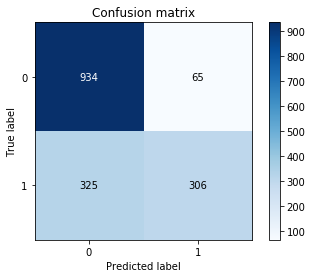

In [41]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,[0,1],False)

Normalized confusion matrix


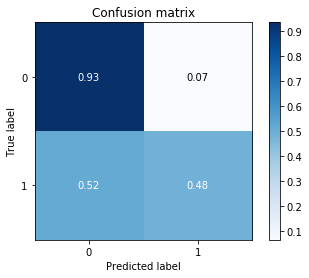

In [42]:
plot_confusion_matrix(cm,[0,1],True)

Confusion matrix, without normalization


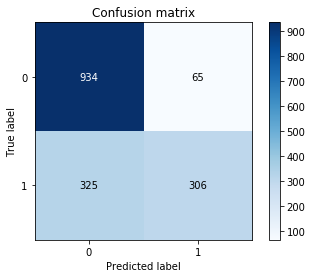

In [43]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,[0,1],False)

Normalized confusion matrix


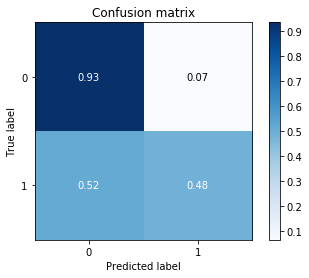

In [44]:
plot_confusion_matrix(cm,[0,1],True)

## Accuracy

In [45]:
clf.score(X_test, y_test)

0.7607361963190185

## Precision

In [46]:
precision_score(y_test,y_pred)

0.8247978436657682

## Recall

In [47]:
recall_score(y_test,y_pred)

0.4849445324881141

## Feature Importances

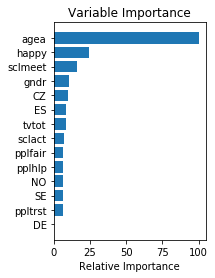

In [48]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()